<a href="https://colab.research.google.com/github/oneextrafact/northbellmoreaccidents/blob/master/processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We start by cloning the repository. This gives us access to the Accident data, which is stored as a file in the repository. 

In [ ]:
!git clone https://github.com/oneextrafact/northbellmoreaccidents.git
!pip install py-staticmaps
!pip install keplergl

fatal: destination path 'northbellmoreaccidents' already exists and is not an empty directory.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We can then read the file using Pandas, and take a look at the first few records. 

In [ ]:
import pandas as pd
data = pd.read_excel('/content/northbellmoreaccidents/data/14995_Event.xlsx')
data.head()

,Case Num,Case Year,County,Comp Muni,Muni Type,Comp Ref Marker,At Intersection,Comp X,Comp Y,Accd Date,...,Apparent Factor Veh 1,Apparent Factor Veh 2,Driver Age Veh 1,Driver Age Veh 2,PRE_ACCD_ACTN_VEH1,PRE_ACCD_ACTN_VEH2,Day_Of_Week,On Street,Closest Cross Street,Parking Lot Ind
0,36597964,2017,NASSAU,Hempstead,3,NaN,Y,624304.260000,4.502363e+06,02/07/2017,...,FOLLOWING TOO CLOSELY,NOT APPLICABLE,27.0,59.0,MAKING LEFT TURN,MAKING LEFT TURN,Tue,MERRICK RD,CENTRE AVE,N
1,36256459,2016,NASSAU,Hempstead,3,27 03041109,Y,624482.930001,4.503029e+06,06/10/2016,...,FOLLOWING TOO CLOSELY,NOT APPLICABLE,22.0,57.0,STARTING IN TRAFFIC,STOPPED IN TRAFFIC,Fri,BEDFORD AVE,SUNRISE HWY,N
2,36353939,2016,NASSAU,Hempstead,3,27 03041113,N,625039.410625,4.503191e+06,08/23/2016,...,FAILURE TO YIELD RIGHT OF WAY,NOT APPLICABLE,24.0,63.0,MAKING RIGHT TURN,GOING STRAIGHT AHEAD,Tue,SUNRISE HWY,NaN,N
3,36302077,2016,NASSAU,Hempstead,3,27 03041104,N,623673.206414,4.502756e+06,07/18/2016,...,REACTION TO OTHER UNINVOLVED VEHICL,NOT APPLICABLE,63.0,49.0,GOING STRAIGHT AHEAD,STOPPED IN TRAFFIC,Mon,SUNRISE HWY,Brevoort Pl,N
4,37046374,2017,NASSAU,Hempstead,3,NaN,N,624784.331751,4.503035e+06,12/21/2017,...,FAILURE TO YIELD RIGHT OF WAY,NOT APPLICABLE,30.0,67.0,MAKING LEFT TURN,GOING STRAIGHT AHEAD,Thu,BELLMORE AVE,ROYLE ST,N


The coordinates for the Accident are in UTM zone 18N (EPSG 32618), rather than the latitude and longitude. We want to convert these to latitude and longitude so we can visualize them using mapping software. We'll use PROJ to do that. Applying a projection transform to the coordinates of the first accident and mapping it using py-staticmaps gives us the intersection of Merrick Rd and Centre Avenue, so we know we're on the right track. 

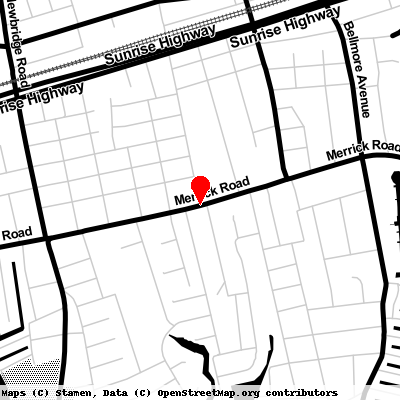

In [ ]:
from pyproj import Transformer
nys_to_wgs_transform = Transformer.from_crs(32618, 4326)
lat, lon = nys_to_wgs_transform.transform(624304.26, 4502362.87)

import staticmaps
context = staticmaps.Context()
context.set_tile_provider(staticmaps.tile_provider_StamenToner)
point = staticmaps.create_latlng(lat, lon)
context.add_object(staticmaps.Marker(point))
img = context.render_pillow(400, 400)
img


We can apply the transformation to all coordinates, which will allow us to map them using Kepler. 

In [ ]:
data['coordinates'] = data.apply(lambda x: nys_to_wgs_transform.transform(x['Comp X'], x['Comp Y']), axis=1)
data['lon'] = data['coordinates'].apply(lambda x: x[1])
data['lat'] = data['coordinates'].apply(lambda x: x[0])
data.head()[['lat', 'lon']]

,lat,lon
0,40.662778,-73.529468
1,40.668747,-73.527223
2,40.670127,-73.520609
3,40.666412,-73.536854
4,40.668755,-73.523657


We have to enable Jupyter widgets so we can use the map directly in our notebook. 

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

We can now us the Kepler map directly in our notebook. This allows us to construct heatmaps, hex bins, and many other visual spatial analyses. 

In [ ]:
from keplergl import KeplerGl
map = KeplerGl(height=800)
map.add_data(data[['lat', 'lon']])
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'unnamed': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,…